<h1><center>EDGE DETECTION ALGORITHMS</center></h1>

In [1]:
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
img = cv2.cvtColor(cv2.imread('Lenna.png'), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_d = np.array(img)

<h2>In ảnh<h2>

In [3]:
def print_img(imgs):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1), plt.imshow(imgs[0], cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 2), plt.imshow(imgs[1], cmap='gray')
    plt.title('My algorithm'), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 3), plt.imshow(imgs[2], cmap='gray')
    plt.title('OpenCV'), plt.xticks([]), plt.yticks([])
    plt.show()

<h2>Gradient Operation</h2>

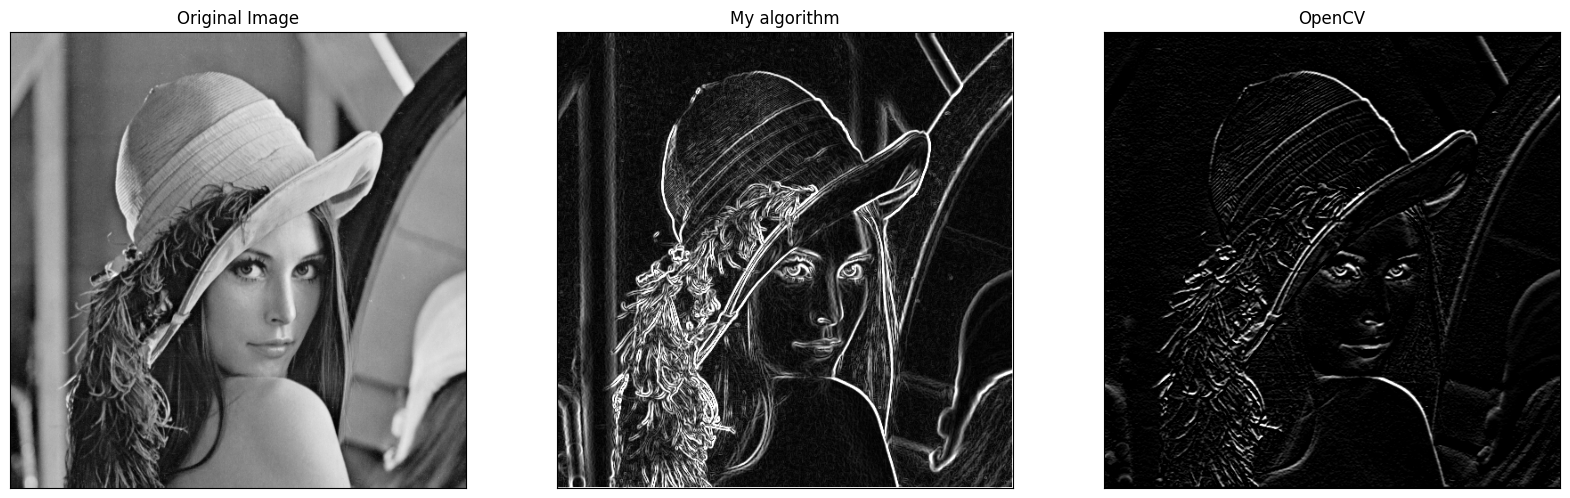

In [4]:
def Sobel_ope(img_d):
    sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply the gradient operator
    sobelx = signal.convolve2d(img_d, sobel_kernel_x, mode='same')
    sobely = signal.convolve2d(img_d, sobel_kernel_y, mode='same')

    # Compute the magnitude of the gradients
    res = np.sqrt(sobelx**2 + sobely**2)

    return np.clip(res, 0, 255).astype('uint8')

# Display the original image and the gradient magnitude
imgs = [img, Sobel_ope(img_d), cv2.Sobel(img_d, cv2.CV_8U, 0, 1, ksize=3)]
print_img(imgs)

<h2>Laplace Operator</h2>

    Laplace

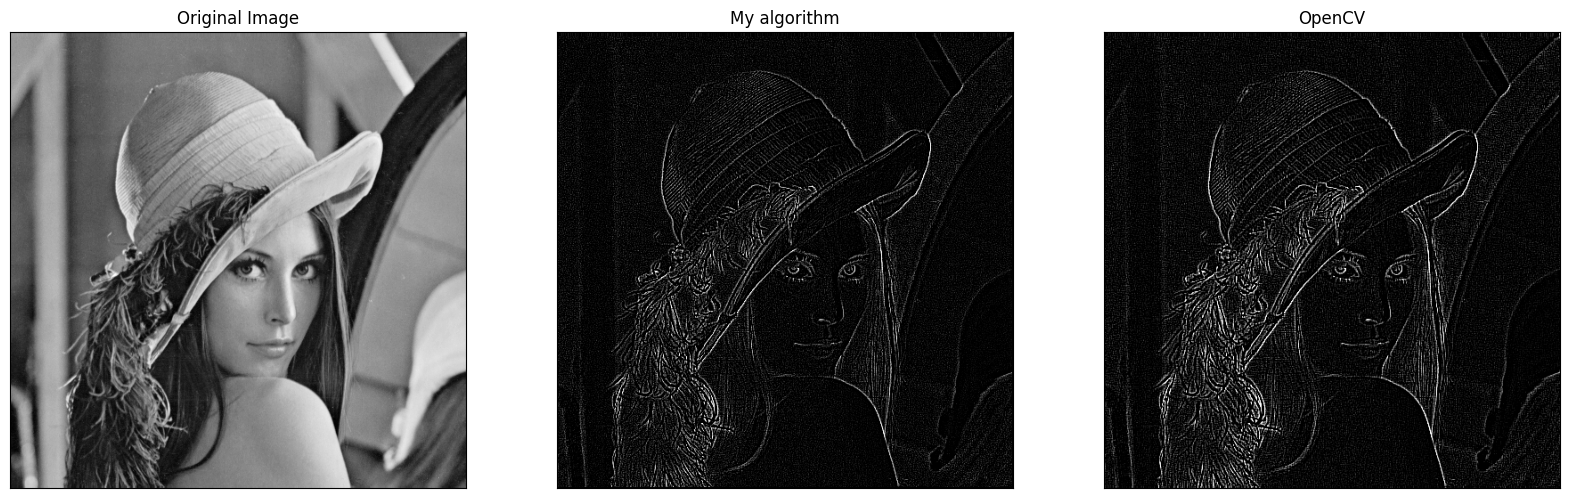

In [5]:
def Laplace(img_d):
    laplace_kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])

    # Apply the gradient operator
    res = signal.convolve2d(img_d, laplace_kernel, mode='same')

    return np.clip(res, 0, 255).astype('uint8')

# Display the original image and the gradient magnitude
imgs = [img, Laplace(img_d), cv2.Laplacian(img_d, cv2.CV_8U, ksize=3)]
print_img(imgs)

    Laplace with Gaussian

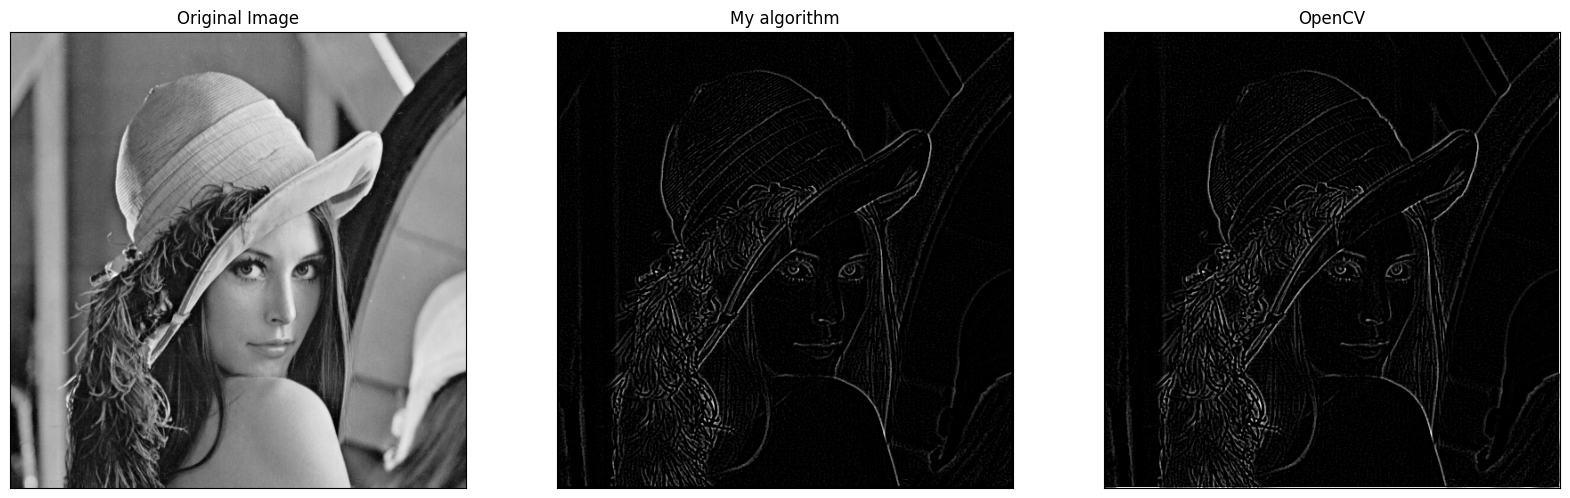

In [6]:
def Gaussian_blur(img_d):
    Gauss_kernel = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], np.float64)
    return np.clip(signal.convolve2d(img_d, Gauss_kernel, mode='same'),0,255).astype('uint8')

def Laplace_Gaussian(img_d):
    laplace_kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    res = signal.convolve2d(Gaussian_blur(img_d), laplace_kernel, mode='same')

    return np.clip(res, 0, 255).astype('uint8')

imgs = [img, Laplace_Gaussian(img_d), cv2.Laplacian(Gaussian_blur(img_d), cv2.CV_8U, ksize=3)]
print_img(imgs)

    Canny Method

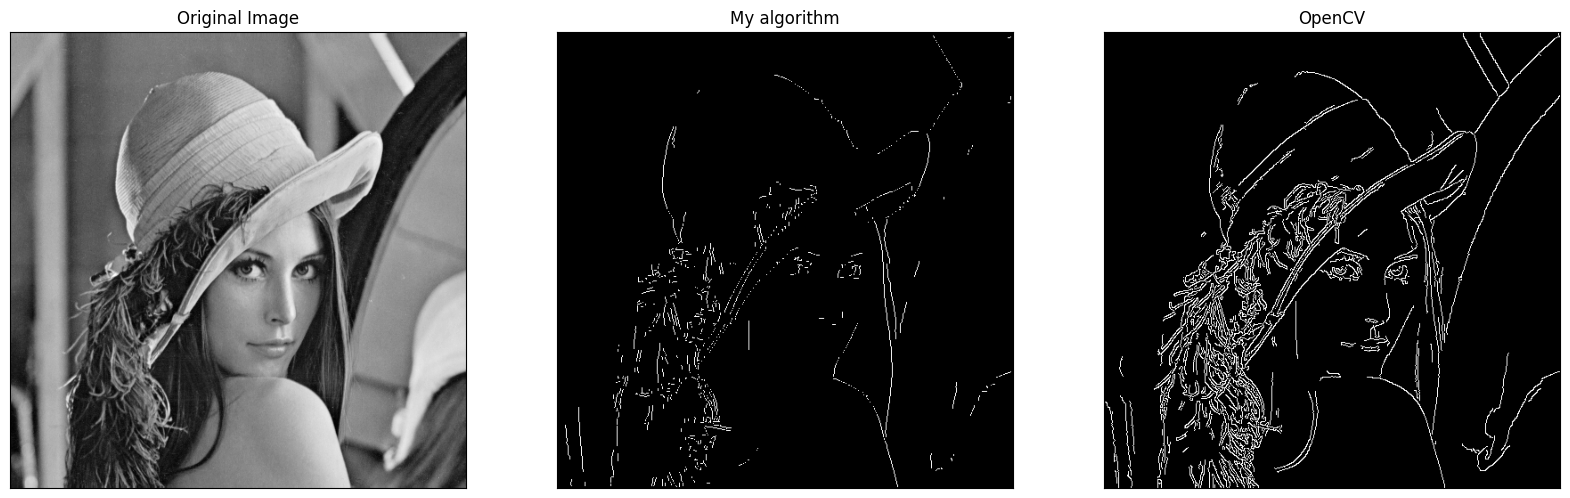

In [7]:
def Canny_Method(img_d):
    img_d = img_d.astype('float64')
    smoothed_img = Gaussian_blur(img_d)
    
    sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply the gradient operator
    sobelx = signal.convolve2d(smoothed_img, sobel_kernel_x, mode='same')
    sobely = signal.convolve2d(smoothed_img, sobel_kernel_y, mode='same')

    # Compute the itensity gradient of the image
    gradient_mag = np.sqrt(sobelx**2 + sobely**2)
    gradient_orient = np.arctan2(sobely, sobelx) 

    # Non-maximum suppression
    gradient_mag_max = np.zeros(img_d.shape)
    angle = gradient_orient * 180. / np.pi  #convert angle from radians to degrees
    angle[angle < 0] += 180          # all angles is between 0 and 360

    for i in range(1, img_d.shape[0]-1):
        for j in range(1, img_d.shape[1]-1):
            left_pixel, right_pixel = 255, 255
            #Angle is calculated clockwise from the vertical axis
            #Angle 0 is vertical
            if (0 <= angle[i,j] < 22.2) or (157.5 <= angle[i,j] <= 180):
                left_pixel = gradient_mag[i, j-1]
                right_pixel = gradient_mag[i, j+1]
            #Angle 45 is diagonal right
            elif (22.5 <= angle[i,j] < 67.5):
                left_pixel = gradient_mag[i+1, j-1]
                right_pixel = gradient_mag[i-1, j+1]
            #Angle 90 is horizontal
            elif (67.5 <= angle[i,j] < 112.5):
                left_pixel = gradient_mag[i-1, j]
                right_pixel = gradient_mag[i+1, j]
            #Angle 135 is diagonal left
            elif (112.5 <= angle[i,j] < 157.5):
                left_pixel = gradient_mag[i-1, j-1]
                right_pixel = gradient_mag[i+1, j+1]

            if (gradient_mag[i,j] >= left_pixel) and (gradient_mag[i,j] >= right_pixel):
                gradient_mag_max[i,j] = gradient_mag[i,j]
            else:
                gradient_mag_max[i,j] = 0

    # Double threshold
    res = np.zeros(img_d.shape)

    weak = np.int32(25)
    strong = np.int32(255)

    for i in range(0, img_d.shape[0]):
        for j in range(0, img_d.shape[1]):
            if (gradient_mag_max[i,j] >= 200):
                res[i,j] = strong
            elif (gradient_mag_max[i,j] >= 100 and img_d[i,j] <= 200):
                res[i,j] = weak
                            
    #hysteresis
    for i in range(1, img_d.shape[0]-1):
        for j in range(1, img_d.shape[1]-1):
            if (res[i,j] == weak):
                if ((res[i-1, j] == strong) or (res[i-1, j+1] == strong) or (res[i, j+1] == strong) or (res[i+1, j+1] == strong) or (res[i+1, j] == strong) or (res[i+1, j-1] == strong) or (res[i, j-1] == strong) or (res[i-1, j-1] == strong)):
                    res[i,j] = strong
                else:
                    res[i,j] = 0

    return np.clip(res, 0, 255).astype('uint8')

# Display the original image and the gradient magnitude
imgs = [img, Canny_Method(img_d), cv2.Canny(img_d, 100, 200)]
print_img(imgs)